In [10]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, Trainer, TrainingArguments
import torch
from PIL import Image
import torch.nn as nn
import cv2
from torchvision import transforms
from tqdm.notebook import tqdm
# from ultralytics import YOLO
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import requests
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [11]:
print(torch.__version__)
import torchvision
print(torchvision.__version__)

2.4.0+cpu
0.19.0+cpu


In [12]:

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

### Train

In [13]:
pip install transformers datasets torch torchvision -q

Note: you may need to restart the kernel to use updated packages.


### Get data from API

In [14]:
data = pd.read_parquet("hf://datasets/laion/220k-GPT4Vision-captions-from-LIVIS/lvis_caption_url.parquet")
df = data.head(8000)

## Test Yolo

In [15]:
pip install ultralytics -q

Note: you may need to restart the kernel to use updated packages.


In [16]:
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.tasks import attempt_load_one_weight

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
import torch
import ultralytics
from ultralytics import YOLO

print(ultralytics.__version__)

# Load the YOLOv8 model
model_yolo = YOLO('yolov8n.pt')

# Access the backbone layers
backbone = model_yolo.model.model[:10]  # Layers 0 to 9 form the backbone

# Create a new Sequential model with just the backbone layers
backbone_model = torch.nn.Sequential(*backbone)

8.3.35


In [18]:
class FeatureExtractorModel(nn.Module):
    def __init__(self, backbone_model):
        super(FeatureExtractorModel, self).__init__()
        self.backbone_model = backbone_model
        self.preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def preprocess_image(self, image):
        tensor_image = self.preprocess(image).unsqueeze(0)  # Thêm batch dimension
        return tensor_image

    def forward(self, image):
        # Tiền xử lý ảnh
        image_tensor = self.preprocess_image(image)

        # Trích xuất đặc trưng với backbone model
        with torch.no_grad():
            features = self.backbone_model(image_tensor)
        
        # Kiểm tra và điều chỉnh kích thước đầu ra của features
        if features.shape[1] != 3 or features.shape[2:] != (224, 224):
            features = torch.nn.functional.interpolate(features, size=(224, 224), mode='bilinear', align_corners=False)
            features = features[:, :3, :, :]  # Chỉ giữ 3 kênh đầu

        return features

# Sử dụng FeatureExtractorModel để trích xuất đặc trưng từ ảnh
feature_extractor = FeatureExtractorModel(backbone_model)

In [19]:
def caption_preprocess(caption):
    # convert to lowercase
    caption = caption.lower()
    # delete digits, special  chars, etc, ..
    caption = caption.replace('[^A-Za-z]', '')
    # delete additional spaces
    caption = caption.replace('\s+', ' ')
    return caption

In [20]:
from transformers import default_data_collator
from torch.utils.data import DataLoader

# Giả sử bạn có các danh sách ảnh và caption
image_paths = df['url']  # Danh sách đường dẫn tới ảnh
captions = df['caption']  # Danh sách các caption tương ứng

# Hàm để xử lý từng ảnh và caption
def process_data(image_url, caption):
    # Load và preprocess image từ URL
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)

    # Đọc ảnh bằng OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Chuyển đổi từ BGR (OpenCV) sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
    pixel_values = feature_extractor(image_rgb).squeeze()
    
    # Tiền xử lý caption
    caption = caption_preprocess(caption)
    
    # Tokenize caption
    tokenized_caption = tokenizer(caption, padding="max_length", max_length=315, truncation=True).input_ids
    
    return {"pixel_values": pixel_values, "labels": tokenized_caption}
    
# Dataset class
class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, captions):
        self.image_paths = image_paths
        self.captions = captions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return process_data(self.image_paths[idx], self.captions[idx])

# Tạo dataset và dataloader
full_dataset = ImageCaptionDataset(image_paths, captions)

# Chia dataset thành train và test (90% train, 10% test)
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Tạo DataLoader cho train và test
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=default_data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=default_data_collator)


In [21]:
from transformers import AutoModelForVision2Seq

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/working/outputv22'

# Tải mô hình VisionEncoderDecoder
model = AutoModelForVision2Seq.from_pretrained(model_path)

In [22]:
# In ra cấu trúc của encoder (Yolov8)
print("Encoder (ViT) Summary:")
print(feature_extractor)

# In ra cấu trúc của decoder (GPT-2)
print("\nDecoder (GPT-2) Summary:")
print(model.decoder)

Encoder (ViT) Summary:
FeatureExtractorModel(
  (backbone_model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       

In [23]:
# from torch.optim import AdamW
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Cấu hình optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5)

# # Hàm huấn luyện
# def train_model(model, dataloader, optimizer, epochs=1):
#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0
#         for batch in dataloader:
#             pixel_values = batch["pixel_values"].to(device)
#             print(pixel_values.shape)
#             labels = batch["labels"].to(device)
            
#             outputs = model(pixel_values=pixel_values, labels=labels)
#             loss = outputs.loss
#             total_loss += loss.item()

#             # Backpropagation
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")

#     # Lưu mô hình sau khi huấn luyện
#     save_path = '/kaggle/working/outputv23/'
#     model.save_pretrained(save_path)
#     print(f"Model saved to {save_path}")
# # Huấn luyện mô hình
# train_model(model, train_dataloader, optimizer)


torch.Size([3, 408, 612])


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


torch.Size([1, 3, 224, 224])


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


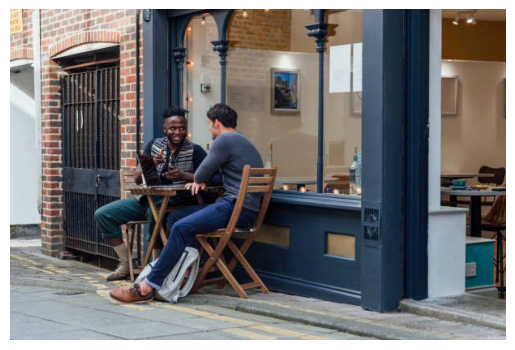

a man and a woman in a living room setting, with the woman wearing glasses and a dark coat, sitting on a sofa using her laptop. there is an armchair nearby, and the room has multiple curtains on windows. the man appears to be focused or contemplative as he looks at his mobile phone. the image gives a cozy and indoor atmosphere reminiscent ofliteral living rooms in older times, suggesting a serene and intimate moment.


In [24]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/working/outputv23/'


# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path)

def predict_caption(image_path):
    # Mở ảnh và chuyển đổi thành RGB
    image = Image.open(image_path).convert("RGB")
    
    # Chuyển đổi ảnh thành tensor trước khi truyền vào feature_extractor
    transform_to_tensor = transforms.ToTensor()

    image_tensor = transform_to_tensor(image)  # Thêm batch dimension
    print(image_tensor.shape)

    # Trích xuất đặc trưng từ ảnh
    pixel_values = feature_extractor(image_tensor)
    print(pixel_values.shape)
    
    # Sinh chú thích cho ảnh
    output_ids = model.generate(
                pixel_values
                ,max_length=150 
                ,min_length=10
                ,temperature=0.8
                # ,top_k=50
                # ,top_p=0.9
                # ,num_beams=5
                ,repetition_penalty=1.2 
                ,early_stopping=True
            )
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # Hiển thị ảnh và chú thích
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    return caption

# Thử tạo caption cho một ảnh mới
image_path = "/kaggle/input/test-img/img5.jpg"
print(predict_caption(image_path))

## Ảnh mạng

a young girl running on a grassy field with a colorful kite in her hand. she is wearing a striped shirt and jeans. there are two other people visible in the background. the kite has multiple colors, including red, blue, and yellow. the girl is running on the grassy field with the kite trailing behind her to her left side. the environment suggests a park or open field. the mood appears joyful, indicating a pleasant, sunny day outdoors. the kite has a vibrant design with multiple colors, including red, blue, and yellow. the girl's attire and the presence of other people suggest a warmer climate, possibly spring or summer.


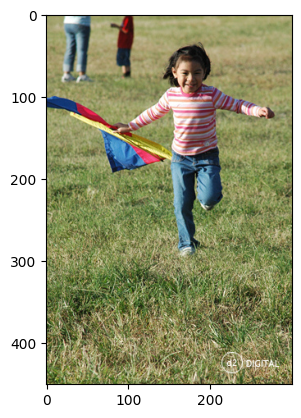

In [25]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/working/outputv23'


# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path)

    
# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path):
    response = requests.get(image_path)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    # Đọc ảnh bằng OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Chuyển đổi từ BGR (OpenCV) sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
    pixel_values = feature_extractor(image_rgb)
    
    output_ids = model.generate(
                pixel_values
                ,max_length=150 
                ,min_length=10
#                 ,temperature=0.8
#                 ,top_k=50
#                 ,top_p=0.9
#                 ,num_beams=5
#                 ,repetition_penalty=1.2 
                ,early_stopping=True
            )
    
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    plt.imshow(image_rgb)
    return caption
image_path = "http://images.cocodataset.org/val2017/000000399462.jpg"
print(predict_internet_caption(model, image_path))

# Evaluate

In [26]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/working/outputv23'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path)

# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path):
    response = requests.get(image_path)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    # Đọc ảnh bằng OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Chuyển đổi từ BGR (OpenCV) sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
    pixel_values = feature_extractor(image_rgb)
    
    output_ids = model.generate(
                pixel_values
                ,max_length=150 
                ,min_length=10
                ,early_stopping=True
            )
    
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    plt.imshow(image_rgb)
    return caption

In [27]:
# test_df = df.tail(100)

# # validate với test data
# actual, predicted = {}, {}

# # Duyệt qua từng ảnh trong tập test
# for index, row in tqdm(test_df.iterrows()):
#     # Lấy actual caption từ cột 'caption'
#     captions = [row['caption']]
#     image_url = row['url']
    
#     # Dự đoán caption cho ảnh từ URL
#     y_pred = predict_internet_caption(model, image_url)
    
#     # Thêm các kết quả vào từ điển
#     # Sử dụng chỉ số index làm khóa
#     actual[index] = captions  # Actual captions là danh sách chuỗi
#     predicted[index] = [y_pred]  # Predicted captions là danh sách chứa một chuỗi

In [28]:
# # # Đường dẫn đến file để lưu kết quả
# output_file = "caption_results_23ep_100.json"

# # Tạo cấu trúc dữ liệu cần lưu
# results = {
#     "actual": actual,
#     "predicted": predicted
# }

# # Ghi dữ liệu vào file JSON
# with open(output_file, "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=4)

# print(f"Kết quả đã được lưu vào file: {output_file}")


## Evaluate

In [29]:
# Đọc dữ liệu từ file JSON
def load_predict_result(output_file):
    with open(output_file, "r", encoding="utf-8") as f:
        loaded_results = json.load(f)

    actual = loaded_results["actual"]
    predicted = loaded_results["predicted"]
    print("Dữ liệu đã được tải lại thành công!")
    return actual, predicted

In [30]:
!pip install rouge-score -q
!pip install pycocoevalcap -q

In [31]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [32]:
# Tính BLEU scores
def bleu_score(actual, predicted):
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_1, bleu_2, bleu_3, bleu_4

In [33]:
from rouge_score import rouge_scorer

def rouge_score(actual, predicted):
    # Tạo scorer tính các loại ROUGE hợp lệ
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lưu điểm cho từng loại ROUGE
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    # Tính điểm ROUGE cho từng cặp câu
    for index in actual.keys():
        actual_caption = " ".join(actual[index])  # Ghép các từ thành chuỗi
        predicted_caption = " ".join(predicted[index])  # Ghép các từ thành chuỗi

        # Tính điểm cho cặp hiện tại
        scores = scorer.score(actual_caption, predicted_caption)

        # Lưu điểm F1 cho từng loại
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Tính điểm trung bình cho từng loại ROUGE
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_avg = sum(rouge2_scores) / len(rouge2_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    # Trả về ba giá trị ROUGE1, ROUGE2, ROUGEL
    return rouge1_avg, rouge2_avg, rougeL_avg


In [34]:
def evaluate(caption_result_file_name='caption_results_10ep_100.json'):
    actual, predicted = load_predict_result(caption_result_file_name)
    
    bleu_1, bleu_2, bleu_3, bleu_4 = bleu_score(actual, predicted)
    
    rouge1, rouge2, rougeL = rouge_score(actual, predicted)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)
    
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(actual, predicted)
    
    evaluation_scores = {
            'bleu_1': bleu_1,
            'bleu_2': bleu_2,
            'bleu_3': bleu_3,
            'bleu_4': bleu_4,
            'rouge1': rouge1,
            'rouge2': rouge2,
            'rougeL': rougeL,
            'cider_score': cider_score,
            'meteor_score': meteor_score
        }
    return evaluation_scores

In [35]:
# List để lưu kết quả
all_results = []

# Vòng lặp từ 10 đến 23 để xử lý các file
for i in range(10, 24):
    # Đọc dữ liệu từ file JSON
    file_name = f"caption_results_{i}ep_100.json"
    
    # Gọi hàm evaluate_scores để lấy kết quả cho từng file
    evaluation_scores = evaluate(file_name)
    
    # Thêm số lượng epoch vào kết quả
    evaluation_scores['epoch'] = i
    
    # Thêm kết quả vào list
    all_results.append(evaluation_scores)

# Chuyển danh sách kết quả thành DataFrame
df_scores = pd.DataFrame(all_results)

# In DataFrame để kiểm tra
print(df_scores)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


    bleu_1    bleu_2    bleu_3    bleu_4    rouge1    rouge2    rougeL  \
0     0.88  0.938083  0.958692  0.968547  0.436216  0.179341  0.298019   
1     0.88  0.938083  0.958692  0.968547  0.459010  0.205419  0.322329   
2     0.88  0.938083  0.958692  0.968547  0.477567  0.232352  0.343770   
3     0.88  0.938083  0.958692  0.968547  0.537514  0.310574  0.412177   
4     0.88  0.938083  0.958692  0.968547  0.537514  0.310574  0.412177   
5     0.88  0.938083  0.958692  0.968547  0.528974  0.304541  0.399477   
6     0.88  0.938083  0.958692  0.968547  0.583706  0.383479  0.470571   
7     0.88  0.938083  0.958692  0.968547  0.627980  0.436895  0.519689   
8     0.88  0.938083  0.958692  0.968547  0.667840  0.500635  0.570647   
9     0.88  0.938083  0.958692  0.968547  0.656139  0.497410  0.566902   
10    0.88  0.938083  0.958692  0.968547  0.698919  0.551644  0.611800   
11    0.88  0.938083  0.958692  0.968547  0.731337  0.609172  0.656592   
12    0.88  0.938083  0.958692  0.9685

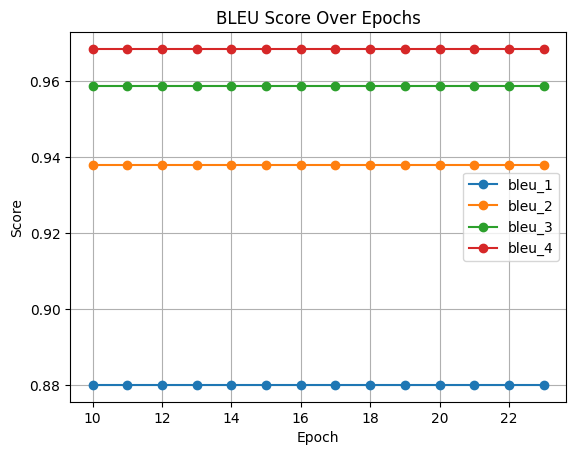

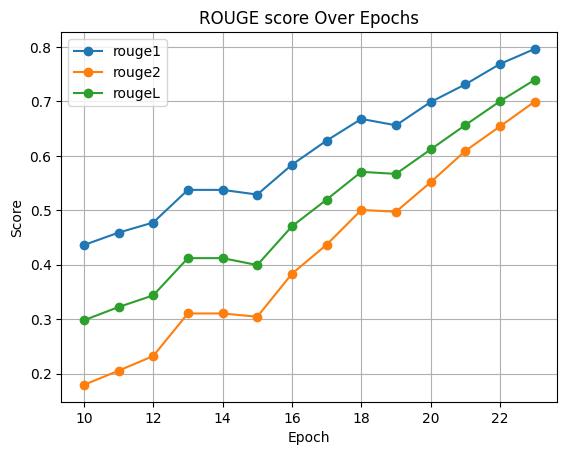

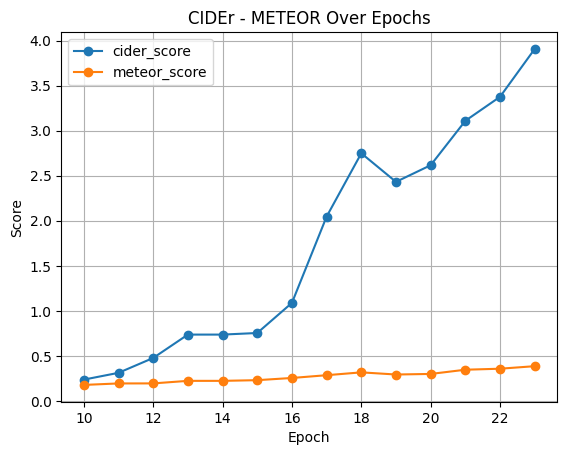

In [36]:
import matplotlib.pyplot as plt

# Lựa chọn các cột cần vẽ
bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
cider_meteor_metrics = ['cider_score', 'meteor_score']

# Vẽ biểu đồ cho từng chỉ số
def plot_evaluate_score(metrics, title="title"):
    for metric in metrics:
        plt.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_evaluate_score(bleu_metrics, "BLEU Score Over Epochs")
plot_evaluate_score(rouge_metrics, "ROUGE score Over Epochs")
plot_evaluate_score(cider_meteor_metrics, "CIDEr - METEOR Over Epochs")
